# Application of Genetic Algorithm and Neural Networks in Stock Trading

In [1]:
import numpy as np
from network import flatten_NN, reconstruct_NN
from typing import List, Tuple
from mate import mate
import pandas as pd
import matplotlib.pyplot as plt
from helper_module import split_train_set, split_train_test_sets
from numpy.typing import NDArray
from fitness import fitness, regime, compute_population_fitness, evaluate_nn
from initialize_nn import initialize_nn, init_nn
from initialize_population import initialize_population, init_population
from selection import keep_elites, selection
import random
from mate import mate, reproduce_population, reduce_population
from checkpoint import checkpoint, load_checkpoint
from evolution import run_evolution
import os
from collections import namedtuple
from activation_function import ActivationFunction


                Close       Open       High        Low   Volume
Date                                                           
1986-01-02   172.6575   172.6575   172.6575   172.6575    600.0
1986-01-03   172.6575   172.6575   172.6575   172.6575   1900.0
1986-01-06   175.4879   175.4879   175.4879   175.4879   2800.0
1986-01-07   181.1488   175.4879   181.1488   175.4879   3200.0
1986-01-09   181.1488   181.1488   181.1488   181.1488   2600.0
...               ...        ...        ...        ...      ...
2023-09-12  1781.0000  1786.0000  1809.0000  1781.0000  12985.0
2023-09-13  1787.0000  1799.0000  1799.0000  1781.0000  16850.0
2023-09-14  1795.0000  1795.0000  1795.0000  1782.0000  12070.0
2023-09-15  1752.0000  1795.0000  1810.0000  1752.0000  29105.0
2023-09-18  1752.0000  1789.0000  1789.0000  1752.0000  27225.0

[8861 rows x 5 columns]


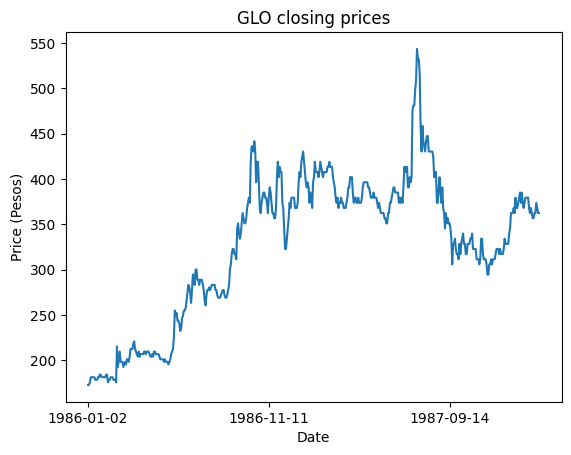

In [2]:
# read and print sample historical stock price data
series = pd.read_csv('../../Data/PH-historical-stock-price-data-csv/GLO.csv', header = 0, index_col = 'Date')
print(series)

# plot historical stock price data
fig, ax = plt.subplots()    
ax.set_title('GLO closing prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price (Pesos)')
ax.plot(series['Close'].head(500))
ax.set_xticks(ax.get_xticks()[::200])
plt.show()

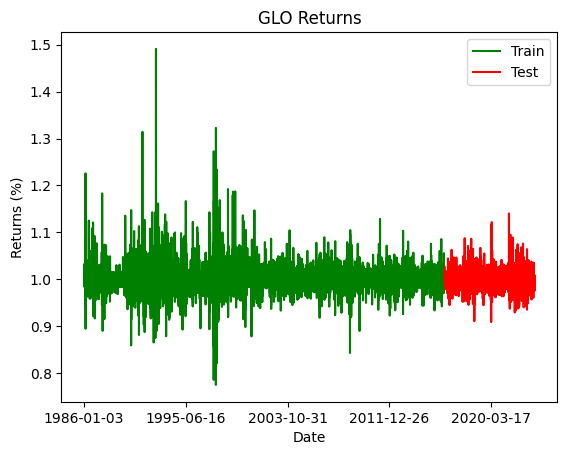

In [3]:
# use only the closing prices of the stock
series = series['Close']
series = series.pct_change(1) + 1
series = pd.Series(data = series, name = 'Close_pct_change')

# split data into train and test sets
train, test = split_train_test_sets(series)

# plot the train and test sets
fig, ax = plt.subplots()    
ax.set_title('GLO Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Returns (%)')
ax.plot(train, 'g', label = 'Train')
ax.plot(test, 'r', label = 'Test')
ax.set_xticks(ax.get_xticks()[::2000])
ax.legend()
plt.show()

In [4]:
# # split the train set into multiple batches
# train_set = split_train_set(train)

# # plot a sample of the train set
# fig, ax = plt.subplots()    
# ax.set_title('GLO closing prices percent change')
# ax.set_xlabel('Date')
# ax.set_ylabel('Percent change')
# ax.plot(train_set[0], 'g')
# ax.set_xticks(ax.get_xticks()[::100])
# plt.show()

In [5]:
nn_layer_topology = namedtuple('nn_layer_topology', ['input_dim', 'output_dim', 'activation_function', 'enable_layernorm'])

nn_layer1 = nn_layer_topology(input_dim = 250, 
                              output_dim =125, 
                              activation_function = ActivationFunction.tanh, 
                              enable_layernorm = True)
nn_layer2 = nn_layer_topology(input_dim = 125, 
                              output_dim = 70, 
                              activation_function = ActivationFunction.tanh, 
                              enable_layernorm = True)
nn_layer3 = nn_layer_topology(input_dim = 70, 
                              output_dim = 35, 
                              activation_function = ActivationFunction.tanh, 
                              enable_layernorm = True)
nn_layer4 = nn_layer_topology(input_dim = 35, 
                              output_dim = 15, 
                              activation_function = ActivationFunction.tanh, 
                              enable_layernorm = True)
nn_layer5 = nn_layer_topology(input_dim = 15, 
                              output_dim = 8, 
                              activation_function = ActivationFunction.tanh, 
                              enable_layernorm = True)
nn_layer6 = nn_layer_topology(input_dim = 8, 
                              output_dim = 3, 
                              activation_function = ActivationFunction.soft_max, 
                              enable_layernorm = False)

nn_topology = [nn_layer1, nn_layer2, nn_layer3, nn_layer4, nn_layer5, nn_layer6]

In [6]:
population = init_population(nn_topology = nn_topology, num_individuals=100)
WINDOW = 250
MAX_POPULATION = 100
MUTATION_RATE = 0.1
NUM_GENERATIONS = 50
CHECKPOINT_FILEPATH = './checkpoint'
CHECKPOINT_INTERVAL = 10
ENABLE_HYPERMUTATION = True
DROPOUT_RATE = 0.1

# start from generation 0
population = run_evolution(population = population,
                           window = WINDOW, 
                           num_generations = NUM_GENERATIONS, 
                           train_set = train,
                           checkpoint_filepath = CHECKPOINT_FILEPATH,
                           checkpoint_interval = CHECKPOINT_INTERVAL,
                           mutation_rate = MUTATION_RATE,
                           enable_hypermutation = ENABLE_HYPERMUTATION,
                           dropout_rate = DROPOUT_RATE)

In [7]:
# uncomment this cell if starting from a checkpoint
# population = load_checkpoint(checkpoint_filepath = './checkpoint/40.pkl')
# population = run_evolution(population = population,
#                            window = WINDOW, 
#                            starting_generation = 41, 
#                            num_generations = NUM_GENERATIONS, 
#                            train_set = train, 
#                            checkpoint_filepath = CHECKPOINT_FILEPATH,
#                            checkpoint_interval = CHECKPOINT_INTERVAL,
#                            mutation_rate = MUTATION_RATE,
#                            enable_hypermutation = ENABLE_HYPERMUTATION,
#                            dropout_rate = DROPOUT_RATE)

Generation: 41 -> 3089.44
Generation: 42 -> 2936.03
Generation: 43 -> 3384.27
Generation: 44 -> 3342.47
Generation: 45 -> 3134.42
Generation: 46 -> 3150.97
Generation: 47 -> 3300.46
Generation: 48 -> 3017.25
Generation: 49 -> 3002.33
Generation: 50 -> 3101.18
Generation: 51 -> 3328.32
Generation: 52 -> 3040.76
Generation: 53 -> 2996.35
Generation: 54 -> 3133.54
Generation: 55 -> 3011.45
Generation: 56 -> 3178.08
Generation: 57 -> 2968.57
Generation: 58 -> 3079.10
Generation: 59 -> 3437.49
Generation: 60 -> 3250.24
Generation: 61 -> 3366.78
Generation: 62 -> 3507.16
Generation: 63 -> 3322.43
Generation: 64 -> 3298.80
Generation: 65 -> 3151.34
Generation: 66 -> 3248.79
Generation: 67 -> 3312.64
Generation: 68 -> 3252.08
Generation: 69 -> 3352.81
Generation: 70 -> 3365.42
Generation: 71 -> 3287.63
Generation: 72 -> 3200.95
Generation: 73 -> 3088.94
Generation: 74 -> 3316.13
Generation: 75 -> 3542.21
Generation: 76 -> 3258.23
Generation: 77 -> 3401.20
Generation: 78 -> 3410.84
Generation: 

In [10]:
for i in range(10):
    test_sample = np.zeros([1,250])
    for i in range(250):
        test_sample[0][i] = np.random.uniform(0,1)

    probabilities = population[0].propagate_forward(test_sample)
    index = np.argmax(probabilities)
    print(probabilities, index)

[[1.09704405e-10 9.99987439e-01 1.25606706e-05]] 1
[[3.25741777e-13 1.00000000e+00 1.78261560e-12]] 1
[[9.96574566e-01 3.42540388e-03 3.00901212e-08]] 0
[[1.12637629e-11 9.99990254e-01 9.74577315e-06]] 1
[[9.70781504e-04 9.99015534e-01 1.36843137e-05]] 1
[[9.99571568e-01 4.28395517e-04 3.65460402e-08]] 0
[[1.05546331e-10 9.99992894e-01 7.10602933e-06]] 1
[[7.98759716e-09 9.99999897e-01 9.48437508e-08]] 1
[[4.83280787e-10 1.00000000e+00 2.18742538e-13]] 1
[[8.42544044e-09 9.99999992e-01 6.03642860e-12]] 1


In [11]:
# check the fitness of all individuals in the population
for individual in population:
    print(individual.fitness)

527974.6817633506
527974.6817633506
527974.6817633506
527974.6817633506
527974.6817633506
527974.6817633506
527974.6817633506
527974.6817633506
527974.6817633506
527974.6817633506


In [13]:
# test_fitness, test_bnh_returns, test_strat_returns, test_max_drawdown, test_series, test_strat_sortino_ratio, test_num_trades = evaluate_nn(nn = population[0], train_set = train_set[2500], regime = regime, window = 300)
test_fitness, test_bnh_returns, test_strat_returns, test_max_drawdown, test_series, test_strat_sortino_ratio, test_num_trades = evaluate_nn(nn = population[0], train_set = train, regime = regime, window = 250)
# test_fitness, test_bnh_returns, test_strat_returns, test_max_drawdown, test_series, test_strat_sortino_ratio, test_num_trades = evaluate_nn(nn = population[0], train_set = test, regime = regime, window = 250)

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(test_series)

            Close_pct_change  Regime   Returns  Cumulative_Returns
Date                                                              
1986-01-03          1.000000     NaN  1.000000            0.000000
1986-01-06          1.016393     NaN  1.000000            0.000000
1986-01-07          1.032258     NaN  1.000000            0.000000
1986-01-09          1.000000     NaN  1.000000            0.000000
1986-01-10          1.000000     NaN  1.000000            0.000000
1986-01-13          1.000000     NaN  1.000000            0.000000
1986-01-14          1.000000     NaN  1.000000            0.000000
1986-01-15          0.984375     NaN  1.000000            0.000000
1986-01-17          1.000000     NaN  1.000000            0.000000
1986-01-20          1.000000     NaN  1.000000            0.000000
1986-01-21          1.015873     NaN  1.000000            0.000000
1986-01-22          1.000000     NaN  1.000000            0.000000
1986-01-23          1.015625     NaN  1.000000            0.00

In [15]:
print(test_bnh_returns)
print(test_fitness)
print(test_strat_returns)
print(test_num_trades)
print(test_max_drawdown)

1220.5334260023449
527974.6817633506
8116.769967333393
3
0.9927362226236253


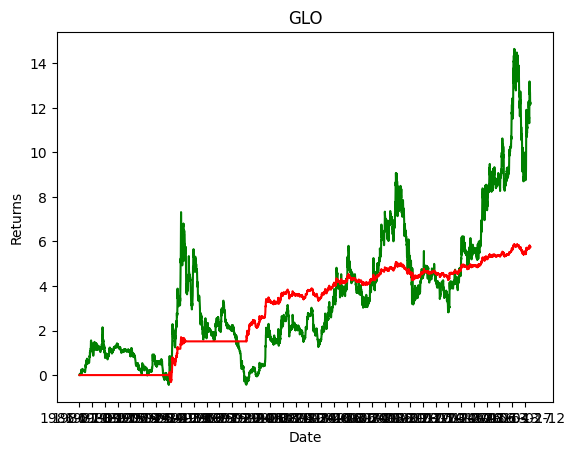

In [16]:
test_series['bnh'] = test_series['Close_pct_change'].cumprod() - 1

# plot historical stock price data
fig, ax = plt.subplots()    
ax.set_title('GLO')
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.plot(test_series.index, test_series['bnh'], color = 'g')
ax.plot(test_series.index, test_series['Cumulative_Returns'], color = 'r')
ax.set_xticks(ax.get_xticks()[::200])
plt.show()

In [ ]:
# checkpoint(population = population, generation_number = 99999, checkpoint_filepath = './checkpoint')